In [1]:
from langchain_openai import AzureChatOpenAI

import os

llm = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
)

In [3]:
# how to integrate tool calls in langgrap

# bind tool/function to the LLM

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_tool

@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers"""

    return first_number * second_number

model_with_tools = llm.bind(tools = [convert_to_openai_tool(multiply)])

In [4]:
response = model_with_tools.invoke("what is 35 * 46?")


print(response)

content='' additional_kwargs={'tool_calls': [{'id': 'call_HP2SxZE4FSMOOuCYUpYQxO3b', 'function': {'arguments': '{"first_number":35,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 56, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b705f0c291', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_

In [5]:
tool_calls = response.additional_kwargs.get('tool_calls')

In [6]:
for tool_call in tool_calls:
    print('function name:', tool_call.get('function').get('name'))
    print('function arguments:', tool_call.get('function').get('arguments'))

function name: multiply
function arguments: {"first_number":35,"second_number":46}


In [7]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [8]:
# router to decide if it should make a call tool or not
from langgraph.graph import StateGraph, END
import json

graph = StateGraph(AgentState)

def invoke_model(state: AgentState):
    messages = state["messages"]
    question = messages[-1]
    return {"messages": [model_with_tools.invoke(question)]}

graph.add_node("agent", invoke_model)

def invoke_tool(state: AgentState):
    tool_calls = state['messages'][-1].additional_kwargs.get('tool_calls', [])
    multiply_call = None

    for tool_call in tool_calls:
        if tool_call.get("function").get("name") == "multiply":
            multiply_call = tool_call
    
    if multiply_call is None:
        raise Exception("No adder input found.")
    
    res = multiply.invoke(
        json.loads(multiply_call.get("function").get("arguments"))
    )

    return {"messages": [res]}


In [9]:
graph.add_node("tool", invoke_tool)

graph.add_edge("tool", END)

graph.set_entry_point("agent")

In [10]:
def router(state: AgentState):

    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])

    if len(tool_calls):
        return "multiply"
    else:
        return "end"

graph.add_conditional_edges("agent", router, {"multiply":"tool", "end": END})

In [11]:
app = graph.compile()

output = app.invoke({"messages": ["what is 123 * 456??"]})

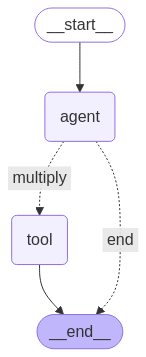

In [12]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [13]:
output["messages"][-1]

56088

In [14]:
output = app.invoke({"messages": ["what is the capital of france"]})

In [16]:
inputs = {"messages": ["what is the capital of mexico?"]}

for output in app.stream(inputs):

    for key, value in output.items():
        print(f"output from node {key} ")
        print("----")
        print(value)

output from node agent 
----
{'messages': [AIMessage(content='The capital of Mexico is Mexico City.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 55, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ded0d14823', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_